<a id='sec0'></a>
# Mutation and Mutation Type Frequencies among Classes
- Importing Data
- <a href='#sec1'>Convertin 'Variant' into Mutation Types</a>
- <a href='#sec2'>Mutation Type Frequency in each Class</a>
- <a href='#sec3'>Convertin 'Variant' into Mutation Types</a>
- <a href='#sec4'>Refactor Mutation Type Converstion into a Function</a>
- <a href='#sec5'>Test Classification with RandomForest </a>

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

sns.set_context("paper")
%matplotlib inline

<b>Importing train_variants</b>

In [2]:
class_train = pd.read_csv('./train_variants')

In [3]:
class_train.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
print('Number of entries = %d' % len('class_train'))

Number of entries = 11


<a id='sec1'></a>
## Convertin 'Variant' into Mutation Types (<a href='#sec0'>Back To Top</a>)

In [5]:
point_mutation_pattern = \
        r"[ARNDCEQGHILKMFPSTWYV]{1}[0-9]{1,4}[ARNDCEQGHILKMFPSTWYV*]?$"

In [6]:
class_train['mutation_type'] = class_train['Variation']

In [7]:
major_types = ['Truncation', 'Point Mutation', 'Deletion', 'Promoter Mutations',
       'Amplification', 'Epigenetic', 'Frame Shift', 'Overexpression',
       'Deletion-Insertion', 'Duplication', 'Insertion',
       'Gene Subtype', 'Fusion', 'Splice', 'Copy Number Loss', 'Wildtype']

In [8]:
class_train.loc[(class_train['Variation'].str.match(point_mutation_pattern)), 'mutation_type']= 'Point Mutation'
class_train.loc[(class_train['Variation'].str.contains('missense', case=False)), 'mutation_type']= 'Point Mutation'
class_train.loc[(class_train['Variation'].str.contains('fusion', case=False)), 'mutation_type']= 'Fusion'
class_train.loc[(class_train['Variation'].str.contains('deletion', case=False)), 'mutation_type']= 'Deletion'
class_train.loc[((class_train['Variation'].str.contains('del', case=False))\
               & (class_train['Variation'].str.contains('delins', case=False) == False)), 
                'mutation_type']= 'Deletion'
class_train.loc[((class_train['Variation'].str.contains('ins', case=False))\
               & (class_train['Variation'].str.contains('delins', case=False) == False)), 
                'mutation_type']= 'Insertion'
class_train.loc[((class_train['Variation'].str.contains('del', case=False))\
               & (class_train['Variation'].str.contains('delins', case=False))), 
                'mutation_type']= 'Deletion-Insertion'
class_train.loc[(class_train['Variation'].str.contains('dup', case=False)), 'mutation_type']= 'Duplication'
class_train.loc[(class_train['Variation'].str.contains('trunc', case=False)), 'mutation_type']= 'Truncation'
class_train.loc[(class_train['Variation'].str.contains('fs', case=False)), 'mutation_type']= 'Frame Shift'
class_train.loc[(class_train['Variation'].str.contains('splice', case=False)), 'mutation_type']= 'Splice'
class_train.loc[(class_train['Variation'].str.contains('exon', case=False)), 'mutation_type']= 'Point Mutation'
class_train.loc[((class_train['Variation'].str.contains('EGFR', case=False))\
                |(class_train['Variation'].str.contains('AR', case=True))\
                |(class_train['Variation'].str.contains('MYC-nick', case=True))\
                |(class_train['Variation'].str.contains('TGFBR1', case=True))\
                |(class_train['Variation'].str.contains('CASP8L', case=True))),
                'mutation_type']= 'Gene Subtype'
class_train.loc[((class_train['Variation'].str.contains('Hypermethylation', case=False))\
                |(class_train['Variation'].str.contains('Epigenetic', case=False))),
                'mutation_type']= 'Epigenetic'
class_train.loc[(class_train['mutation_type'].isin(major_types) == False),
                'mutation_type']= 'Others'

In [9]:
len(class_train['mutation_type'].unique())

17

In [10]:
class_train['mutation_type'].unique()

array(['Truncation', 'Point Mutation', 'Deletion', 'Promoter Mutations',
       'Amplification', 'Epigenetic', 'Frame Shift', 'Overexpression',
       'Gene Subtype', 'Deletion-Insertion', 'Duplication', 'Insertion',
       'Fusion', 'Splice', 'Copy Number Loss', 'Others', 'Wildtype'], dtype=object)

In [11]:
# rearrange order of columns
class_train = class_train[['ID', 'Gene', 'Variation', 'mutation_type', 'Class']]

<a id='sec2'></a>
## Mutation Type Frequency in each Class (<a href='#sec0'>Back To Top</a>)

In [12]:
d1 =class_train[['mutation_type', 'Class']].groupby(['Class','mutation_type']).size().unstack('mutation_type')

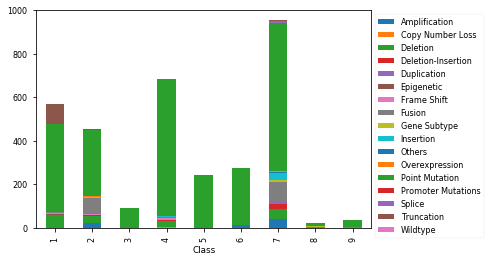

In [13]:
d1.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

In [14]:
d2 = d1.copy()
for i in range(len(d2)):
    d2.iloc[i] /= np.sum(d2.iloc[i])

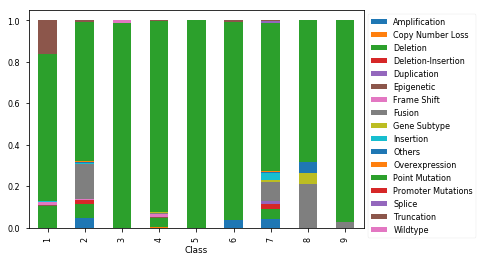

In [15]:
d2.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

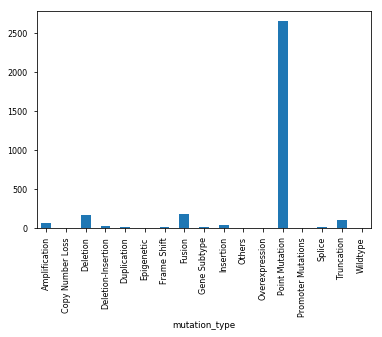

In [16]:
class_train.groupby('mutation_type').size().plot(kind='bar', stacked=True)

<i>Most of the data contains point mutations and other types are much rarer!!</i><br>
So now check for ones that do have other types of mutations

In [17]:
non_point_mutants = class_train[class_train.mutation_type != 'Point Mutation']

In [18]:
d3 =non_point_mutants[['mutation_type', 'Class']].groupby(['Class','mutation_type'])\
                                        .size().unstack('mutation_type')

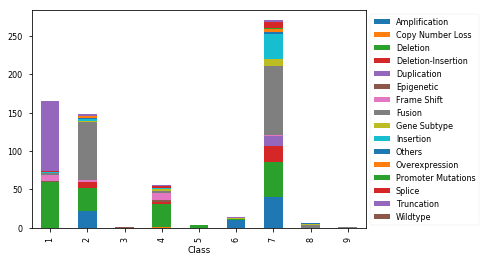

In [19]:
d3.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

In [20]:
d4 = d3.copy()
for i in range(len(d4)):
    d4.iloc[i] /= np.sum(d4.iloc[i])

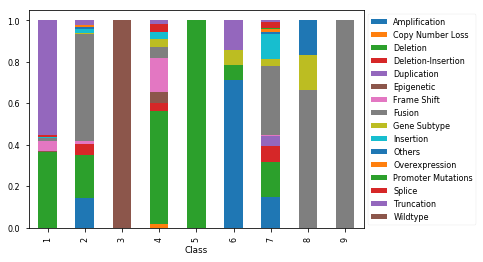

In [21]:
d4.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

In [22]:
d5 =class_train[['mutation_type', 'Class']].groupby(['Class','mutation_type']).size().unstack('Class')

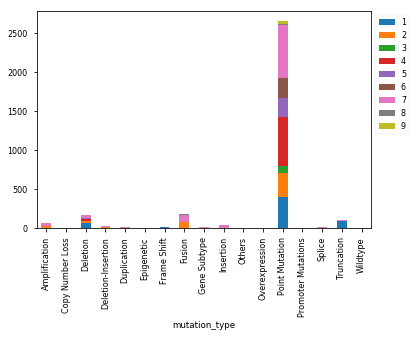

In [23]:
d5.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

In [24]:
d6 = d5.copy()
for i in range(len(d6)):
    d6.iloc[i] /= np.sum(d6.iloc[i])

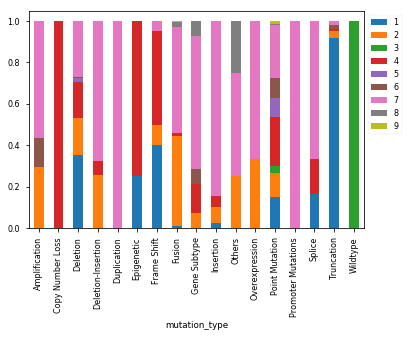

In [25]:
d6.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

<a id='sec3'></a>
## Gene Frequency in each Class (<a href='#sec0'>Back To Top</a>)

In [26]:
print('# Genes (total) = %d' % len(class_train.Gene))
print('# Genes (unique) = %d' % len(class_train.Gene.unique()))

# Genes (total) = 3321
# Genes (unique) = 264


In [27]:
g1 = class_train.groupby(['Gene', 'Class']).size().unstack('Gene')

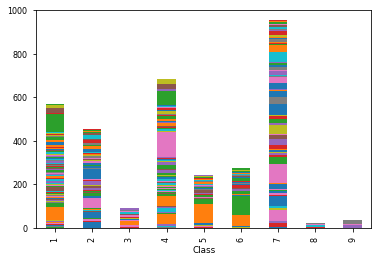

In [28]:
g1.plot(kind='bar', stacked=True, legend=False)

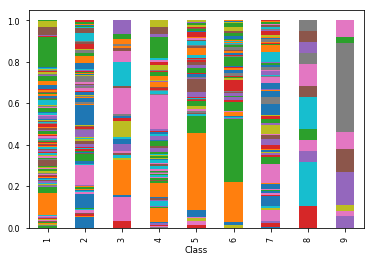

In [29]:
g2 = g1.copy()
for i in range(len(g2)):
    g2.iloc[i] /= np.sum(g2.iloc[i])
g2.plot(kind='bar', stacked=True, legend=False)

In [30]:
g3 = class_train.groupby(['Gene', 'Class']).size().unstack('Class')
g3 = g3.fillna(value=0)

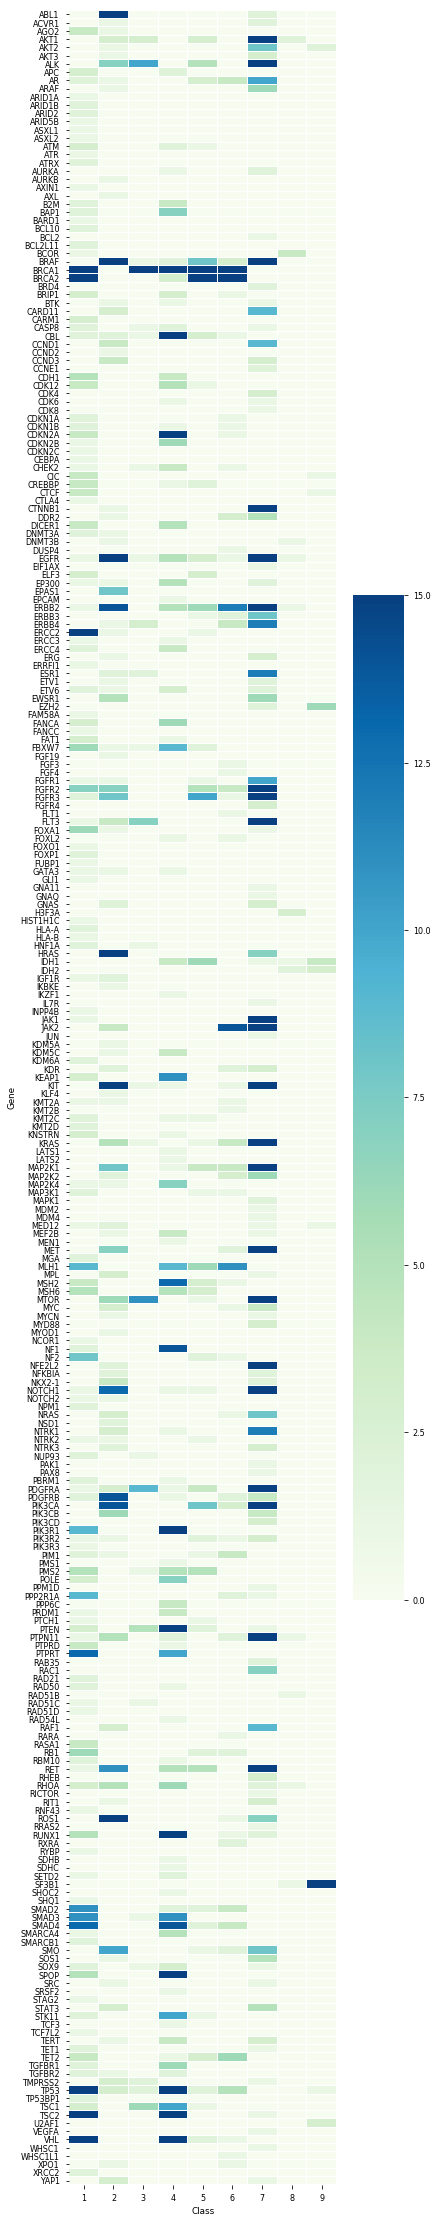

In [31]:
plt.figure(figsize=(6, 40))
sns.heatmap(g3, robust=True, cmap='GnBu', linewidths=.02)

<a id='sec4'></a>
## Refactor Mutation Type Converstion into a Function (<a href='#sec0'>Back To Top</a>)

In [32]:
def convert_mutation_type(data):
    '''
    Convert the 'Variant' Data into mutation_type in a new column, returns the new data with a new column
    
    Input
    =====
    data : DataFrame
        The train or test data containing Variant information
    
    Output
    ======
    data : DataFrame
        'mutation_type' is added to the original data from the input
    '''
    # Copy the Variation into a new column (this could be just an empty copy with Nones)
    data['mutation_type'] = data['Variation']
    
    # Define regex pattern for point mutants
    point_mutation_pattern = \
        r"[ARNDCEQGHILKMFPSTWYV]{1}[0-9]{1,4}[ARNDCEQGHILKMFPSTWYV*]?$"
    
    # Define new mutation types
    major_types = ['Truncation', 'Point Mutation', 'Deletion', 'Promoter Mutations',
       'Amplification', 'Epigenetic', 'Frame Shift', 'Overexpression',
       'Deletion-Insertion', 'Duplication', 'Insertion',
       'Gene Subtype', 'Fusion', 'Splice', 'Copy Number Loss', 'Wildtype']
    
    # Convert the Variant information to mutation types
    data.loc[(data['Variation'].str.match(point_mutation_pattern)), 'mutation_type']= 'Point Mutation'
    data.loc[(data['Variation'].str.contains('missense', case=False)), 'mutation_type']= 'Point Mutation'
    data.loc[(data['Variation'].str.contains('fusion', case=False)), 'mutation_type']= 'Fusion'
    data.loc[(data['Variation'].str.contains('deletion', case=False)), 'mutation_type']= 'Deletion'
    data.loc[((data['Variation'].str.contains('del', case=False))\
            &(data['Variation'].str.contains('delins', case=False) == False)), 
            'mutation_type']= 'Deletion'
    data.loc[((data['Variation'].str.contains('ins', case=False))\
            &(data['Variation'].str.contains('delins', case=False) == False)), 
            'mutation_type']= 'Insertion'
    data.loc[((data['Variation'].str.contains('del', case=False))\
            &(class_train['Variation'].str.contains('delins', case=False))), 
            'mutation_type']= 'Deletion-Insertion'
    data.loc[(data['Variation'].str.contains('dup', case=False)), 'mutation_type']= 'Duplication'
    data.loc[(data['Variation'].str.contains('trunc', case=False)), 'mutation_type']= 'Truncation'
    data.loc[(data['Variation'].str.contains('fs', case=False)), 'mutation_type']= 'Frame Shift'
    data.loc[(data['Variation'].str.contains('splice', case=False)), 'mutation_type']= 'Splice'
    data.loc[(data['Variation'].str.contains('exon', case=False)), 'mutation_type']= 'Point Mutation'
    data.loc[((data['Variation'].str.contains('EGFR', case=False))\
            |(data['Variation'].str.contains('AR', case=True))\
            |(data['Variation'].str.contains('MYC-nick', case=True))\
            |(data['Variation'].str.contains('TGFBR1', case=True))\
            |(data['Variation'].str.contains('CASP8L', case=True))),
            'mutation_type']= 'Gene Subtype'
    data.loc[((data['Variation'].str.contains('Hypermethylation', case=False))\
            |(data['Variation'].str.contains('Epigenetic', case=False))),
             'mutation_type']= 'Epigenetic'
    data.loc[(data['mutation_type'].isin(major_types) == False),
            'mutation_type']= 'Others'
    
    # rearrange order of columns
    if 'Class' in data.columns:
        data = data[['ID', 'Gene', 'Variation', 'mutation_type', 'Class']]
    else:
        data = data[['ID', 'Gene', 'Variation', 'mutation_type']]
    
    return data

In [34]:
class_train = pd.read_csv('./train_variants')
class_test = pd.read_csv('./test_variants')

In [35]:
convert_mutation_type(class_test).head()

,ID,Gene,Variation,mutation_type
0,0,ACSL4,R570S,Point Mutation
1,1,NAGLU,P521L,Point Mutation
2,2,PAH,L333F,Point Mutation
3,3,ING1,A148D,Point Mutation
4,4,TMEM216,G77A,Point Mutation


In [36]:
convert_mutation_type(class_train).head()

,ID,Gene,Variation,mutation_type,Class
0,0,FAM58A,Truncating Mutations,Truncation,1
1,1,CBL,W802*,Point Mutation,2
2,2,CBL,Q249E,Point Mutation,2
3,3,CBL,N454D,Point Mutation,3
4,4,CBL,L399V,Point Mutation,4


Looks like the function works!

<a id='sec5'></a>
## Test Classification with RandomForest (<a href='#sec0'>Back To Top</a>)
- Had to use train set because class labels are not available for the test set

In [116]:
data = pd.read_csv('./train_variants')

In [117]:
data = convert_mutation_type(data)

In [118]:
data = data.dropna()

In [119]:
data[data.columns[1:-1]].head()

,Gene,Variation,mutation_type
0,FAM58A,Truncating Mutations,Truncation
1,CBL,W802*,Point Mutation
2,CBL,Q249E,Point Mutation
3,CBL,N454D,Point Mutation
4,CBL,L399V,Point Mutation


In [120]:
X = np.array(data[data.columns[1:-1]])
y = np.array(data[data.columns[-1]]).astype(int).ravel()

In [121]:
for i in range(X.shape[1]):
    le = LabelEncoder()
    X[:, i] = le.fit_transform(X[:, i])
X = X.astype(int)

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [172]:
%%time
rfc = RandomForestClassifier(n_estimators=50, max_depth=30)
rfc.fit(X_train, y_train)

CPU times: user 110 ms, sys: 3.95 ms, total: 114 ms
Wall time: 114 ms


In [173]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [174]:
y_pred = rfc.predict(X_test)

In [175]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='micro'))
print(recall_score(y_test, y_pred, average='micro'))
print(f1_score(y_test, y_pred, average='micro'))

0.527819548872
0.527819548872
0.527819548872
0.527819548872


In [176]:
from sklearn.naive_bayes import MultinomialNB

In [177]:
%%time
nb = MultinomialNB()
nb.fit(X_train, y_train)

CPU times: user 286 µs, sys: 1.84 ms, total: 2.13 ms
Wall time: 1.46 ms


In [178]:
y_pred = nb.predict(X_test)

In [179]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='micro'))
print(recall_score(y_test, y_pred, average='micro'))
print(f1_score(y_test, y_pred, average='micro'))

0.224060150376
0.224060150376
0.224060150376
0.224060150376


As expected, it doesn't work wel, but considering there are 9 classes, ~50% is not so a bad start(?).